## Supervised Learning
## Project: Finding Donors for *CharityML*

## Project

Fictional organization, CharityML has observed that people who donate the organization have income of above $50 000. It needs help in predicting from publicly available info about individuals whether they have such income or not. This will help CharityML to minimize the cost of sending mail while maximizing donation yield.

The goal of the project is to find and tune the best supervised learning model that will predict income of above $50 000, based on data containing 13 features from US census.

## Exploring the Data

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames

# Import supplementary visualization code visuals.py
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

# Load the Census dataset
data = pd.read_csv("census.csv")

# Display the first record
display(data.head(n=1))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K


------
** Outcome Variable Exploration **

In [2]:
# Total number of records
n_records = len(data)

# Number of records where individual's income is more than $50,000
n_greater_50k = len(data[data['income'] == ">50K"])

# Number of records where individual's income is at most $50,000
n_at_most_50k = len(data[data['income'] == "<=50K"])

# Percentage of individuals whose income is more than $50,000
greater_percent = n_greater_50k / n_records * 100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {:.2f}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78%


** Featureset Exploration **

* **age**: continuous. 
* **workclass**: Private, Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked. 
* **education**: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc, 9th, 7th-8th, 12th, Masters, 1st-4th, 10th, Doctorate, 5th-6th, Preschool. 
* **education-num**: continuous. 
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse. 
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces. 
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried. 
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other. 
* **sex**: Female, Male. 
* **capital-gain**: continuous. 
* **capital-loss**: continuous. 
* **hours-per-week**: continuous. 
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

----
## Preparing the Data

### Transforming Skewed Continuous Features
Some algorithms may be sensitive to skewness of data, therefore check if any such variables are present.

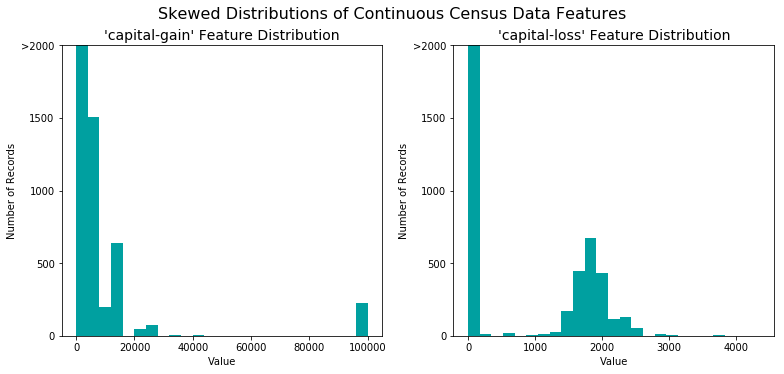

In [3]:
# Split the data into features and target label
income_raw = data['income']
features_raw = data.drop('income', axis = 1)

# Visualize skewed continuous features of original data
vs.distribution(data)

Apply logarithmic transformation to remove the skewness.

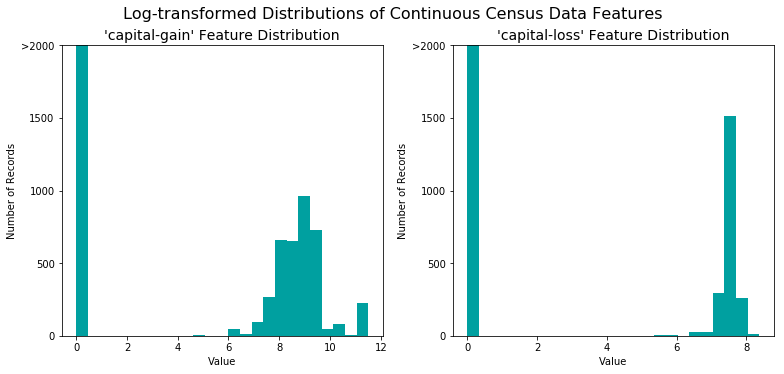

In [4]:
# Log-transform the skewed features
skewed = ['capital-gain', 'capital-loss']
features_log_transformed = pd.DataFrame(data = features_raw)
features_log_transformed[skewed] = features_raw[skewed].apply(lambda x: np.log(x + 1))

# Visualize the new log distributions
vs.distribution(features_log_transformed, transformed = True)

### Normalizing Numerical Features
Normalizing numerical features because some algorithms may need it to perform well.

In [5]:
# Import sklearn.preprocessing.StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() # default=(0, 1)
numerical = ['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

features_log_minmax_transform = pd.DataFrame(data = features_log_transformed)
features_log_minmax_transform[numerical] = scaler.fit_transform(features_log_transformed[numerical])

# Show an example of a record with scaling applied
display(features_log_minmax_transform.head(n = 5))

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


### Data Preprocessing
Use one-hot encoding for categorical variables. 

Transform the outcome variable, so that income above $50k is 1, otherwise it is 0.

In [6]:
# One-hot encode the 'features_log_minmax_transform' data
features_final = pd.get_dummies(features_log_minmax_transform)

# Encode the 'income_raw' data to numerical values
income = np.where(income_raw == '>50K', 1, 0)

# Print the number of features after one-hot encoding
encoded = list(features_final.columns)
print("{} total features after one-hot encoding.".format(len(encoded)))

103 total features after one-hot encoding.


### Shuffle and Split Data
Now all categorical variables have been converted into numerical features, and all numerical features have been normalized. 
It's time to split split the data into training and test sets in ratio 80:20.

In [7]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_final, 
                                                    income, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


----
## Evaluating Model Performance
In this section, three different algorithms will be investigated to determine which one is best. The fourth *naive* model will be used to compare models against.

### Metrics and the Naive Predictor
*CharityML*, equipped with their research, knows individuals that make more than \$50,000 are most likely to donate to their charity. Because of this, *CharityML* is particularly interested in predicting who makes more than \$50,000 accurately.

The distribution of income variable is skewed, about 3/4 of individuals do not ear nore than $50 000. That is why using *accuracy* as a metric of evaluation would not be good. From *CharityML* perspective, it would be important to identify as many postives as possible (*recall* metric) while also to be accurate in positive predicitons (*precision* metric). This way, organization will reach as many out of potential donors as possible (*recall*) while also reduce the cost of mail by minimizing the number of false positives (*precision*).

For convenience **F-beta score** metric can be used, as it is a harmonic average of *recall* and *precison*. With **beta = 0.5** more emphasis will be put on precision. In *CharityML* context it means that more emphasis is put on optimizing the cost of mail.

The **naive predictor** will be the model that makes a naive assumption that every individual has income below $50 000. This simple model will have a pretty good accuracy of about 75%, but in problem context will also make no sense, as no people would be identified as potential donors to the charity.

### Naive Predictor Performace

In [8]:
# Calculate building elements of metrics
TP = np.sum(income)
FP = len(income) - TP
TN = 0
FN = 0

# Calculate accuracy, precision and recall
accuracy = (TP + TN) / len(income)
recall = TP / (TP + FN)
precision = TP / (TP + FP)

# TODO: Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
beta = 0.5
fscore = (1 + beta**2) * (precision * recall) / (beta**2 * precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.2478, F-score: 0.2917]


### Supervised learning models

Here are three models selected for the problem.

**Logistic regression with L2 regularization**

- Real world application

*Predicting probability of survival among patinets suffering from a given disease based on their individual features.*

- When it performs well?

*It performs well when the response variable is binary. As a high bias, low variance model it generalizes well given a relatively small number of observations. It also makes the model highly interpretable and efficient computationally.*

- When it performs poorly?

*It performs poorly when the response variable contains more than two classes. It is sensitive to collinearity and performs poorly if collinear variables are present. It doesn't perform well when the number of dimenensions is high. Both collinearity and high number of features can be countered with L2 regularization.*

- What makes the model a good candidate given data?

*The response variable is binary. As a high bias, low variance model it should generalize well if linear assumption is not far off. And with this type of data, linear assumption should not be far from the truth.*

**Naive Bayes**

- Real world application

*Spam filter*

- When it performs well?

*It deals well with a lot of features, is unaffected by irrelevant features and rarely overfits.*

- When it performs poorly?

*It makes a naive assumption that the variable are independent. Therefore it performs poorly if this assumption is far from being held.*

- What makes the model a good candidate given data?

*One-hot encoding adds many new variables, a big part of them may have weak correlation with the income. At the same time the assumption of independent variables is not of crucial importance here.*

**Random Forest**

- Real world application

*It is widely used to tackle regression and classification problems.*

- When it performs well?

*It generally performs well. It is unaffected by irrelevant features.*

- When it performs poorly?

*Decision tree has a tendency to overfit. Random Forest uses ensemble methods which makes the model difficult to interpret.*

- What makes the model a good candidate given data?

*The interest is in prediction, not interpretation, which makes the model a good candidate.*

### Creating a Training and Predicting Pipeline

In [9]:
# Import two metrics from sklearn - fbeta_score and accuracy_score
from sklearn.metrics import accuracy_score, fbeta_score

def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size'
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end - start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train)
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # Calculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples
    results['f_train'] = fbeta_score(y_train[:300], predictions_train, beta)
        
    # Compute F-score on the test set
    results['f_test'] =fbeta_score(y_test, predictions_test, beta)
       
    # Success
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### Initial Model Evaluation

LogisticRegression trained on 361 samples.
LogisticRegression trained on 3617 samples.
LogisticRegression trained on 36177 samples.
GaussianNB trained on 361 samples.
GaussianNB trained on 3617 samples.
GaussianNB trained on 36177 samples.
RandomForestClassifier trained on 361 samples.
RandomForestClassifier trained on 3617 samples.
RandomForestClassifier trained on 36177 samples.


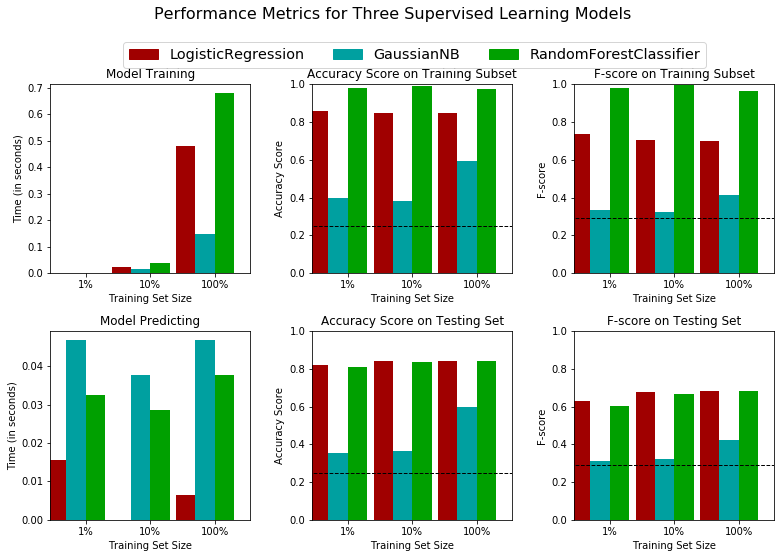

In [10]:
# Import the three supervised learning models from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

# Initialize the three models
clf_A = LogisticRegression(random_state = 42)
clf_B = GaussianNB()
clf_C = RandomForestClassifier(random_state = 42)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(len(y_train) * 0.1)
samples_1 = int(len(y_train) * 0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

----
## Improving Results

### Choosing the Best Model

The most important metric is the F-score on the test data after training on the full dataset. *Logistic regression* and *Random forest* performed on the equal level of about 0.7. The performance of *Naive Bayes* is poor and its score is only about 0.4. Because the higher the score the better, *Naive Bayes* can't be considered as the best model.

When it comes to computational efficiency, *Logistic regression* is better than *Random forest* in training and prediction, because it took less time. What may be the most important difference between these two models it is their fit to the data. *Random forest* model is overfitted, because its F-score on the trainig set is about 0.95 compared to 0.7 on the test set. *Logistic regression* seems to be a good model, because the F-score on both sets is at the same level.

The best model is **Logistic Regression**.

### Describing the Model in Layman's Terms

Logistic regression model takes on values of all the features of an individual and outputs the probability (from 0% to 100%) that he or she has the income of over \\$50 000. During training we find the most effective threshold, e.g. 0.7. *If the resulting probability is at least 0.7, the model will predict that the individual earns more than \\$50 000. If not, it will predict otherwise.*

In the result of training the model, we end up with a mathematical formula. It means that we can make a prediction for an individual quickly, just by substituting x-es with real numbers. Having a formula is even more important - it means that we can understand the relation between certain features and the prediction. E.g. (values are made up) *On average, being a 1 year older, makes an individual 5% more likely to have income of above \\$50 000*.

### Model Tuning

In [11]:
# Import 'GridSearchCV', 'make_scorer', and any other necessary libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# Initialize the classifier
clf = LogisticRegression(random_state = 42)

# Create the parameters list to tune, using a dictionary if needed.
parameters = {
    'penalty' : [ 'l2' ],
    'solver' : [ 'lbfgs' ],
    'C' : [ 0.01, 0.05, 0.1, 0.15, 0.25, 0.5, 0.75, 0.9 ],
    'class_weight' : [ 'balanced', None ],
}

# Make an fbeta_score scoring object
scorer = make_scorer(fbeta_score, beta = beta)

# Perform grid search on the classifier using 'scorer' as the scoring method
grid_obj = GridSearchCV(clf, parameters, scorer)

# Fit the grid search object to the training data and find the optimal parameters
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)
best_params = grid_fit.best_params_

# Report the before-and-afterscores
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, predictions, beta = 0.5)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))

# Report best set of parameters
print("\nBest set of parameters\n------")
print(best_params)

Unoptimized model
------
Accuracy score on testing data: 0.8419
F-score on testing data: 0.6832

Optimized Model
------
Final accuracy score on the testing data: 0.8425
Final F-score on the testing data: 0.6849

Best set of parameters
------
{'C': 0.15, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}


### Final model evaluation

#### Results:

|     Metric     | Unoptimized Model | Optimized Model |
| :------------: | :---------------: | :-------------: | 
| Accuracy Score |           0.8419  |         0.8425  |
| F-score        |           0.6832  |         0.6849  |


Compared to the initial model, the optimized model is a bit better when it comes to the metrics. It has *accuracy* value higher by 0.0006 and *F-beta score* higher by 0.0017. There was not much room left for optimizng the model's parameters.

----
## Feature Importance

### Initial guess

To understand the relationship between the features and the result better, it is helpful to identify the small subset of features that influence the response variable the most. Based on the 13 features in the data, supposedly the features that influence the individual income the most are in that order:
- education (well educated people should earn more), 
- age (people of middle age tend to have the highest income), 
- occupation (salaries are directly linked with it)
- race (influences access to education and discrimination on the job market)
- sex (in numerous surveys women are reported to earn less)

### Extracting Feature Importance

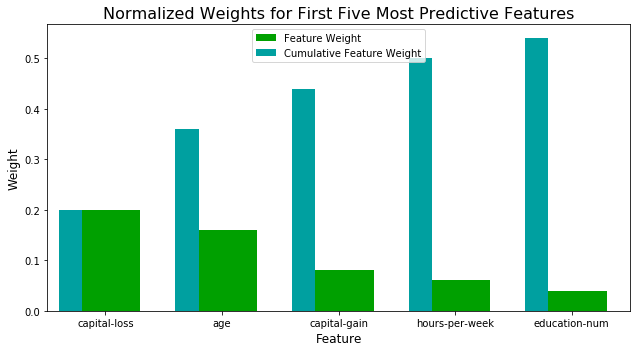

In [12]:
# Import a supervised learning model that has 'feature_importances_'
from sklearn.ensemble import AdaBoostClassifier

# Train the supervised model on the training set
model = AdaBoostClassifier()
model.fit(X_train, y_train)

# Extract the feature importances
importances = model.feature_importances_

# Plot
vs.feature_plot(importances, X_train, y_train)

Initial guess was right when it comes to the most important feature, *education*. Variable *age* is in the top 5 too, but not on the second place as it was guessed but on fourth. 

The remainig important features are:

- hours-per-week (people who work full-time tend to earn more than part-time workers, people who work over-time tend to earn extra)
- capital-gain (people who are high-earners should accumulate significant amounts of money)
- capital-loss (people in the low-earners group or struggling financially probably fall into this group)

### Feature Selection

Compare the best model with its less complex version based on the five most important features.

In [13]:
# Import functionality for cloning a model
from sklearn.base import clone

# Reduce the feature space
X_train_reduced = X_train[X_train.columns.values[(np.argsort(importances)[::-1])[:5]]]
X_test_reduced = X_test[X_test.columns.values[(np.argsort(importances)[::-1])[:5]]]

# Train on the "best" model found from grid search earlier
clf = (clone(best_clf)).fit(X_train_reduced, y_train)

# Make new predictions
reduced_predictions = clf.predict(X_test_reduced)

# Report scores from the final model using both versions of data
print("Final Model trained on full data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, best_predictions, beta = 0.5)))
print("\nFinal Model trained on reduced data\n------")
print("Accuracy on testing data: {:.4f}".format(accuracy_score(y_test, reduced_predictions)))
print("F-score on testing data: {:.4f}".format(fbeta_score(y_test, reduced_predictions, beta = 0.5)))

Final Model trained on full data
------
Accuracy on testing data: 0.8425
F-score on testing data: 0.6849

Final Model trained on reduced data
------
Accuracy on testing data: 0.8053
F-score on testing data: 0.5881


### Effects of feature selection

The final model compared to the less complex model is significantly better. It scores by almost 0,04 higher in *accuracy* value and what's most important, by almost 0.10 higher in *f-beta score*. While the results are surprisingly good after reduction of complexity from initial 13 to reduced number of 5 features, use of more complex model is justified.

### Report generation

In [14]:
!!jupyter nbconvert *.ipynb

['[NbConvertApp] Converting notebook finding-donors.ipynb to html',
 '[NbConvertApp] Writing 442272 bytes to finding-donors.html']